# Gym memberships - A&B test

For this project I will be helping a fancy gym run an A/B test!

Currently, when a person is considering buying a membership at this gym, he or she follows the following steps:

1. Take a fitness test with a personal trainer
2. Fill out an application for the gym
3. Send in their payment for their first month’s membership

The manager decided to run an A/B test, thinking that the fitness test intimidates some prospective members.

Visitors were randomly be assigned to one of two groups:

* Group A - will still be asked to take a fitness test with a personal trainer

* Group B -  will skip the fitness test and proceed directly to the application


### Meneger's hypothesis is that visitors assigned to Group B will be more likely to eventually purchase a membership.


## Plan of the project:

1. Getting started with SQL
2. Separating all gym visitors into A and B groups 
3. Who picks up an application?
4. Who purchases a membership?
5. Summarising and Visualisation

# Step 1: Let's get started with SQL

### I will open and merge all three tables with SQL, which will save them in Pandas DataFrame.

In [2]:
from codecademySQL import sql_query
visits = sql_query('''
SELECT *
FROM visits
LIMIT 5
''')

In [3]:
fitness_tests = sql_query('''
SELECT *
FROM fitness_tests
LIMIT 5
''')


In [4]:
applications = sql_query('''
SELECT *
FROM applications
LIMIT 5
''')


In [5]:
purchases = sql_query('''
SELECT *
FROM purchases
LIMIT 5
''')



### Here I'm going to merge the tables using LEFT JOIN 


In [6]:

df = sql_query('''
SELECT 
    visits.first_name,
    visits.last_name,
    visits.gender,
    visits.email,
    visits.visit_date,
    fitness_tests.fitness_test_date,
    applications.application_date,
    purchases.purchase_date
from visits
LEFT JOIN fitness_tests
   ON fitness_tests.first_name = visits.first_name
   AND fitness_tests.last_name = visits.last_name
   AND fitness_tests.email = visits.email
LEFT JOIN applications
   ON applications.first_name = visits.first_name
   AND applications.last_name = visits.last_name
   AND  applications.email = visits.email
LEFT JOIN purchases
   ON purchases.first_name = visits.first_name
   AND purchases.last_name = visits.last_name
   AND  purchases.email = visits.email
where visits.visit_date >= '7-1-17'
   ''')



In [7]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns



Now I can print the merged table with Pandas and have a first look at the data. 


In [8]:
df.head()

,first_name,last_name,gender,email,visit_date,fitness_test_date,application_date,purchase_date
0,Kim,Walter,female,KimWalter58@gmail.com,7-1-17,2017-07-03,None,None
1,Tom,Webster,male,TW3857@gmail.com,7-1-17,2017-07-02,None,None
2,Edward,Bowen,male,Edward.Bowen@gmail.com,7-1-17,None,2017-07-04,2017-07-04
3,Marcus,Bauer,male,Marcus.Bauer@gmail.com,7-1-17,2017-07-01,2017-07-03,2017-07-05
4,Roberta,Best,female,RB6305@hotmail.com,7-1-17,2017-07-02,None,None



# Step 2: Separating all gym visitors into A and B groups

### I'm going to create a new column, which will separate all visitors into groups A and B and count them.

In [9]:
df['ab_test_group'] = df.fitness_test_date.apply( lambda x : 'A' if pd.notnull(x) else 'B')

In [10]:
ab_counts = df.groupby('ab_test_group').first_name.count().reset_index()
print(ab_counts)

  ab_test_group  first_name
0             A        2504
1             B        2500


# Step 3: Who picks up an application?



### Let's examine how many people make it to Step 2, filling out an application. I'm going to create a new colomn with the information about visitors who filled out an application and count them.

In [11]:

df['is_application'] = df.application_date.apply(lambda x: 'Application' if pd.notnull(x) else 'No Application')

In [12]:
app_total = df.groupby('is_application').first_name.count().reset_index()
print(app_total)


   is_application  first_name
0     Application         575
1  No Application        4429


### From the pie chart below we can see that only 11.49% of all visitors fill out an application.

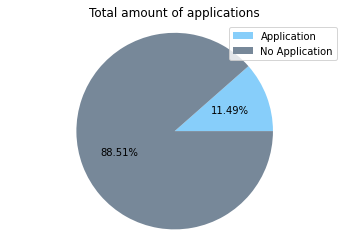

In [13]:
colors = ['#87CEFA', '#778899']
plt.pie(app_total.first_name, autopct = '%0.2f%%' , colors = colors)
plt.axis('equal')
plt.legend(app_total.is_application)
plt.title('Total amount of applications')
plt.show()


### Lets's count how many people applied in each group

In [14]:
app_counts = df.groupby(['ab_test_group','is_application']).first_name.count().reset_index()
app_counts

,ab_test_group,is_application,first_name
0,A,Application,250
1,A,No Application,2254
2,B,Application,325
3,B,No Application,2175


### Let's pivot the table for easier reading

In [15]:
app_pivot = app_counts.pivot(columns='is_application',
                                      index='ab_test_group',
                                      values='first_name')\
                                .reset_index()
app_pivot

is_application,ab_test_group,Application,No Application
0,A,250,2254
1,B,325,2175


### Next, we need to find a percentage of visitors who applied for a membership in both groups

In [16]:
app_pivot['Total'] = app_pivot.Application + app_pivot['No Application']
app_pivot['percentage_applied'] = 100 * app_pivot.Application/app_pivot.Total
app_pivot


is_application,ab_test_group,Application,No Application,Total,percentage_applied
0,A,250,2254,2504,9.984026
1,B,325,2175,2500,13.000000




### We need to know if this difference is statistically significant. Since we have two categorical datasets that we want to compare, then we should run a Chi Square test. In SciPy, we can use the function chi2_contingency to perform a Chi Square test. 


### In this case, the null hypothesis is that there’s no significant difference between the groups. We reject that hypothesis, and state that there is a significant difference between two of the groups if we get a p-value less than 0.05.

In [18]:
from scipy.stats import chi2_contingency

contingency = [[250, 2254], [325, 2175]]
chi2, pval, dof, expected = chi2_contingency(contingency)
print(pval)

0.0009647827600722304


### The test showed that the p-value for these two groups = 0.00096, which is less than 0.05. It means that the difference between the amount of those applied for a membership in our groups is significant in favour of the group B. 

# Step 4: Who purchases a membership?

### Of those who picked up an application, how many purchased a membership?

I'll start by creating a new colomn with those who purchased a membership and follow the same steps as for the previous test. 

In [19]:
df['is_member'] = df.purchase_date.apply(lambda x: 'Member' if pd.notnull(x) else 'Not Member')

### Choosing only the rows with those who applied.

In [20]:
just_apps = df[df.is_application == 'Application']

In [21]:

member_counts = just_apps.groupby(['ab_test_group','is_member']).first_name.count().reset_index()
member_counts


,ab_test_group,is_member,first_name
0,A,Member,200
1,A,Not Member,50
2,B,Member,250
3,B,Not Member,75


### Pivoting the table for easier reading

In [22]:
member_pivot = member_counts.pivot(columns='is_member',
                                      index='ab_test_group',
                                      values='first_name')\
                                .reset_index()
member_pivot

is_member,ab_test_group,Member,Not Member
0,A,200,50
1,B,250,75


### Finding the percentage of visitors who applied for a membership in both groups

In [23]:
member_pivot['Total'] = member_pivot.Member+ member_pivot['Not Member']
member_pivot['percentage_purchased'] = 100*member_pivot.Member/member_pivot.Total
member_pivot

is_member,ab_test_group,Member,Not Member,Total,percentage_purchased
0,A,200,50,250,80.000000
1,B,250,75,325,76.923077




### Now let's test if the difference in purchase percentage is significant comparing the two groops A and B. (Of those who picked up an application)

In [25]:
contingency2 = [[200, 50], [250, 75]]
chi2, pval, fod, expected = chi2_contingency(contingency2)
print(pval)

0.43258646051083327


### The p-value = 0.43 which is greater than 0.05. It means that the results are not significant. 

### Previously, we looked at what percentage of people who picked up applications purchased memberships. What we really care about is what percentage of all visitors purchased memberships. I'm going to come back to the DataFrame df and follow the same process that I did in Step 4, including pivoting the table.

In [26]:
final_member__counts = df.groupby(['ab_test_group','is_member']).first_name.count().reset_index()
final_member__counts

,ab_test_group,is_member,first_name
0,A,Member,200
1,A,Not Member,2304
2,B,Member,250
3,B,Not Member,2250


In [27]:
final_pivot = final_member__counts.pivot(columns='is_member',
                                      index='ab_test_group',
                                      values='first_name')\
                                .reset_index()
final_pivot

is_member,ab_test_group,Member,Not Member
0,A,200,2304
1,B,250,2250


In [28]:
final_pivot['Total'] = final_pivot.Member+ final_pivot['Not Member']
final_pivot['percentage_purchased'] = 100*final_pivot.Member/final_pivot.Total
final_pivot

is_member,ab_test_group,Member,Not Member,Total,percentage_purchased
0,A,200,2304,2504,7.98722
1,B,250,2250,2500,10.00000



### Let's run a Chi Square Test again to compare the results. Remember that the null hypothesis is that there’s no significant difference in purchase percentage between the groups. We reject that hypothesis, and state that there is a significant difference if we get a p-value less than 0.05.

In [29]:
contingency3 = [[200, 2304], [250, 2250]]
chi2, pval, fod, expected = chi2_contingency(contingency3)
print(pval)

0.014724114645783203


### The p-value = 0.014 which is less than 0.05. It means that the results are significant and there's a significant difference in the number of visitors who purchase a membership between the two groups. 

# Step 5. Summarising and Visualisation

### Let's visualise some of the main findings of the project

### Percent of visitors who applied

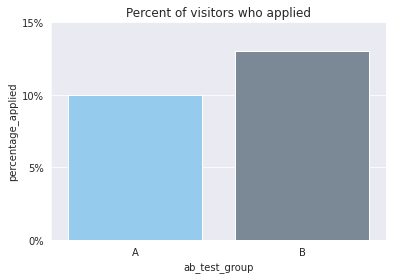

In [32]:
ax = plt.subplot()
colors = ['#87CEFA', '#778899']
sns.set_style('darkgrid')
sns.barplot(data =app_pivot,  x= 'ab_test_group', y ='percentage_applied', palette = colors )
plt.title('Percent of visitors who applied')
ax.set_yticks([0, 5, 10, 15])
ax.set_yticklabels(['0%', '5%', '10%', '15%'])
plt.show()

### Percent of applicants who purchased a membership

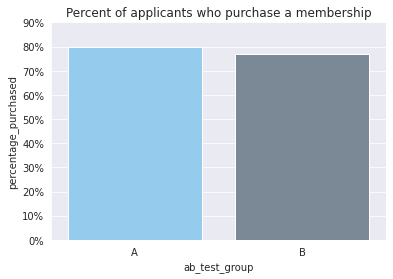

In [33]:
ax = plt.subplot()
sns.set_style('darkgrid')
colors = ['#87CEFA', '#778899']
sns.barplot(data =member_pivot,  x= 'ab_test_group', y ='percentage_purchased', palette = colors)
plt.title('Percent of applicants who purchase a membership')
ax.set_yticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90])
ax.set_yticklabels(['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%'])
plt.show()

### Percent of all visitors who purchase a membership

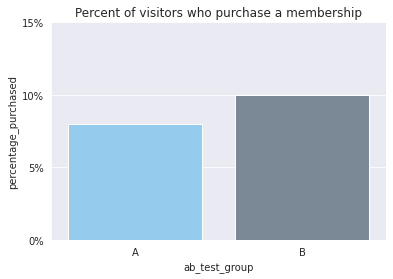

In [226]:
ax = plt.subplot()
sns.set_style('darkgrid')
colors = ['#87CEFA', '#778899']
sns.barplot(data =final_pivot,  x= 'ab_test_group', y ='percentage_purchased', palette = colors)
plt.title('Percent of visitors who purchase a membership')
ax.set_yticks([0, 5, 10, 15])
ax.set_yticklabels(['0%', '5%', '10%', '15%'])
plt.show()

## Conclusion 

5004 visitors were assigned to the groups A and B, 2504 and 2500 respectively:

* Group A - were asked to take a fitness test with a personal trainer

* Group B - skipped the fitness test and proceed directly to the application

Only 11.49% of all visitors fill out an application, from which visitors who don't take a fitness test with a personal trainer are significantly more likely to apply. 

Of those who picked up an application, there's no significant difference in purchased a membership. Applicants of both groups are more likely to make a purchase (around 80%). 

However, the test showed that among all visitors, those who take a fitness test are less likely to buy memberships with a significant difference of 2.1%.


### Manager's hypothesis that visitors assigned to Group B are more likely to purchase a membership confirmed.



